# Overview

The new model CapsuleNet proposed by Sara Sabour (and Geoffry Hinton) claims to deliver state of the art results on [MNIST](https://arxiv.org/abs/1710.09829). The kernel aims to create and train the model using the Kaggle Dataset and then make a submission to see where it actually ends up. Given the constraint of using a Kaggle Kernel means it can't be trained as long as we would like or with GPU's but IMHO if a model can't be reasonably well trained in an hour on a 28x28 dataset, that model probably won't be too useful in the immediate future.

## Implementation Details

* Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
* Code adapted from https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py
*  Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
*     The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
*     Adopting to other backends should be easy, but I have not tested this. 

Result:
    Validation accuracy > 99.5% after 20 epochs. Still under-fitting.
    About 110 seconds per epoch on a single GTX1070 GPU card
    


In [4]:
import numpy as np
#from keras.preprocessing.image import ImageDataGenerator
#from keras import callbacks
import tensorflow as tf
from tensorflow.keras import callbacks
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import re 
from sklearn.model_selection import train_test_split
import shutil

import pandas as pd
print(tf.__version__)
import sys, os
from facenet_pytorch import MTCNN
from PIL import Image
import torch
import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential

2.2.1


# Capsule Layers 
Here is the implementation of the necessary layers for the CapsuleNet. These are not optimized yet and can be made significantly more performant. 

In [3]:

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""

'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

# Build the Model
Here we use the layers to build up the model. The model is a bit different from a standard $X\rightarrow y$  model, it is $(X,y)\rightarrow (y,X)$ meaning it attempts to predict the class from the image, and then at the same time, using the same capsule reconstruct the image from the class. The approach appears very cGAN-like where the task of reconstructing better helps the model 'understand' the image data better.

In [4]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# load model without classifier layers
model = VGG19(include_top=False, input_shape=(299, 299, 3))

In [5]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, routings, batch_size):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :param batch_size: size of batch
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """

    """
    """
    x = layers.Input(shape=input_shape, batch_size=batch_size)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16 * n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

In [6]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    # return tf.reduce_mean(tf.square(y_pred))
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    return tf.reduce_mean(tf.reduce_sum(L, 1))

# Load MNIST Data
Here we load and reformat the Kaggle contest data

In [7]:
from matplotlib import pyplot as plt
from PIL import Image
import csv
import math
import pandas

def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

def plot_log(filename, show=True):

    data = pandas.read_csv(filename)

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()    

def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-' * 30 + 'Begin: test' + '-' * 30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50], x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()

In [89]:
def train(model, data, args):
#def train(model, train_gen, val_gen,args):

    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_accuracy',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield (x_batch, y_batch), (y_batch, x_batch)

    # Training with data augmentation. If shift_fraction=0., no augmentation.
    model.fit(train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
              steps_per_epoch=int(np.shape(y_train)[0] / args.batch_size),
              epochs=args.epochs,
              validation_data=((x_test, y_test), (y_test, x_test)), batch_size=args.batch_size,
              callbacks=[log, checkpoint, lr_decay])
        
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    plot_log(args.save_dir + '/log.csv', show=True)

    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    plot_log(args.save_dir + '/log.csv', show=True)
    return model


In [8]:
import argparse
import os

parser = argparse.ArgumentParser(description="Capsule Network on MNIST.")
parser.add_argument('--epochs', default=10, type=int)
parser.add_argument('--batch_size', default=10, type=int)
parser.add_argument('--lr', default=0.001, type=float,
                        help="Initial learning rate")
parser.add_argument('--lr_decay', default=0.9, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
parser.add_argument('-r', '--routings', default=1, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
parser.add_argument('--shift_fraction', default=0.1, type=float,
                        help="Fraction of pixels to shift at most in each direction.")
parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
parser.add_argument('--save_dir', default='./result')
parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
parser.add_argument('--digit', default=5, type=int,
                        help="Digit to manipulate")
parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
args, unknown = parser.parse_known_args()
print(args)

if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

Namespace(batch_size=10, debug=False, digit=5, epochs=10, lam_recon=0.392, lr=0.001, lr_decay=0.9, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)


In [17]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))

    # data_slice = 10000
    # x_train = x_train[:data_slice,:]
    # y_train = y_train[:data_slice,:]
    # x_test = x_test[:data_slice,:]
    # y_test = y_test[:data_slice,:]

    return (x_train, y_train), (x_test, y_test)

In [9]:
def read_images(path):
    data = []
    filenames = glob.glob(DATASET_PATHS[path]+"*.jpg")
    #pbar = tqdm(filenames)
    #df = pd.DataFrame()
    for image in filenames:
        id = image.split("/")[-1]
        #print(id)
        #id = re.findall(r'\d+',id)[0]
        #og_name = image.split("\\")[-1]
        dataset_type = id.split("_")[0]
        if path == 'original':
            label = 0
            data.append([id, label,dataset_type])
        else: 
            label = 1
            data.append([id, label,dataset_type])
    return data

In [10]:
DATASET_PATHS = {"original":"/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Original_images/",
    "Deepfakes": "/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Mainpulated_images/"
}


In [24]:
data_real = pd.DataFrame(read_images('original'),columns=["id","label","dataset_type"])
data_Deepfakes = pd.DataFrame(read_images('Deepfakes'),columns=["id","label","dataset_type"])


In [25]:
frames = [data_real, data_Deepfakes]
df_data = pd.concat(frames)

In [26]:
df_0 = df_data[df_data['label'] == 0].sample(100, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(100, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle

df_data['label'].value_counts()

ValueError: a must be greater than 0 unless no samples are taken

In [18]:
y = df_data['label']


In [22]:
df_train, df_val = train_test_split(df_train, test_size=0.20, random_state=101, stratify=y)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [17]:
base_dir = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/'


In [ ]:
base_dir = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/'


In [110]:
base_dir = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/'
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

original_os = os.path.join(train_dir, 'Real')
os.mkdir(original_youtube_os)
fake_os = os.path.join(train_dir, 'Fake')
os.mkdir(fake_os)


# create new folders inside val_dir
original_os = os.path.join(val_dir, 'Real')
os.mkdir(original_os)
fake_os = os.path.join(val_dir, 'Real')
os.mkdir(fake_os)

In [112]:
original_youtube_os = os.path.join(train_dir, 'original')
os.mkdir(original_youtube_os)
deepfake_os = os.path.join(train_dir, 'fake')
os.mkdir(deepfake_os)


# create new folders inside val_dir
original_youtube_os = os.path.join(val_dir, 'original')
os.mkdir(original_youtube_os)
deepfake_os = os.path.join(val_dir, 'fake')
os.mkdir(deepfake_os)

In [21]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

NameError: name 'df_train' is not defined

In [19]:
df_train["label"]

141    1
145    1
17     0
65     0
83     0
      ..
128    1
122    1
44     0
25     0
72     0
Name: label, Length: 160, dtype: int64

In [20]:
def build_train_datset(image):
    count = 0
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    count += 1
# get the label for a certain image
    target = df_data.loc[df_data['id'] == fname]['label']
    if target.any() == 0:
        src = os.path.join("/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Original_images/", fname)
        label = 'original_youtube'
    else:
        src = os.path.join("/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Mainpulated_images/",fname)
        label = 'deepfake'
# destination path to image
    dst = os.path.join(train_dir, label,fname)
# copy the image from the source to the destination
    shutil.copyfile(src, dst) 
pbar = tqdm(train_list)
transfer_images = Parallel(n_jobs=4)(delayed(build_train_datset)(t) for t in pbar)


NameError: name 'train_list' is not defined

In [143]:
def build_test_datset(image):
    fname = image
# get the label for a certain image
    target = df_data.loc[df_data['id'] == fname]['label']
    if target.any() == 0:
        src = os.path.join("/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Original_images/", fname)
        label = 'original_youtube'
    else:
        src = os.path.join("/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Mainpulated_images/",fname)
        label = 'deepfake'
# destination path to image
    dst = os.path.join(val_dir,label, fname)
# copy the image from the source to the destination
    shutil.copyfile(src, dst) 
pbar = tqdm(val_list)       
transfer_images = Parallel(n_jobs=4)(delayed(build_test_datset)(t) for t in pbar)

In [23]:
train_path = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/train_dir'
valid_path = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/val_dir'

In [24]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [25]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(299,299),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(299,299),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [126]:
#from itertools import izip, imap
class_mode='binary'
from itertools import zip_longest as izip
x, y = izip(*(val_gen[i] for i in range(len(val_gen))))
x_val = np.vstack(x)
y_val = np.vstack(map(to_categorical, y))[:,0] if class_mode == 'binary' else y


In [128]:
np.shape(y_val)

(40, 2)

In [125]:
#from itertools import izip, imap
class_mode='binary'
from itertools import zip_longest as izip
x, y = izip(*(train_gen[i] for i in range(len(train_gen))))
x_tran = np.vstack(x)
y_tran = np.vstack(map(to_categorical, y))[:,0] if class_mode == 'binary' else y


In [8]:
from tensorflow.keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU

In [118]:
train_features.shape[1:]

(18, 18, 512)

In [116]:

model, eval_model, manipulate_model = CapsNet(input_shape=(18,18,512),n_class=2,routings=args.routings,                    batch_size=args.batch_size)
model.summary()



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(10, 18, 18, 512)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (10, 10, 10, 256)    10617088    input_9[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (10, 1, 1, 256)      5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (10, 32, 8)          0           primarycap_conv2d[0][0]          
____________________________________________________________________________________________

In [111]:
train(model=model, data=((train_features, y_tran), (x_val, y_val)), args=args)


NameError: name 'x_val' is not defined

In [103]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# load model without classifier layers


In [104]:
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(300, 300, 3))

In [117]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [106]:
conv = Sequential()

for layer in conv_base.layers[:18]: # this is where I changed your code
    conv.add(layer)    

# Freeze the layers 
for layer in conv.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.


In [107]:
conv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 75, 75, 256)      

In [108]:
batch_size = 10
datagen = ImageDataGenerator(rescale=1./255)
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 18, 18, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(300, 300),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [122]:
validation_labels.shape[0]

40

In [34]:
train_dir = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/train_dir'
validation_dir = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/val_dir'

In [35]:
num_train_samples = 160
num_val_samples = 40

In [109]:
train_features, train_labels = extract_features(train_dir, num_train_samples)
validation_features, validation_labels = extract_features(validation_dir, num_val_samples)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [74]:
np.shape(train_features)

(160, 18, 18, 512)

In [75]:
np.shape(train_features[0])


(18, 18, 512)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.6221 - capsnet_loss: 0.2469 - decoder_loss: 0.9571 - capsnet_accuracy: 0.4875
Epoch 00001: val_capsnet_accuracy improved from -inf to 0.50000, saving model to ./result/weights-01.h5
16/16 [==============================] - 20s 1s/step - loss: 0.6221 - capsnet_loss: 0.2469 - decoder_loss: 0.9571 - capsnet_accuracy: 0.4875 - val_loss: 0.6275 - val_capsnet_loss: 0.2131 - val_decoder_loss: 1.0571 - val_capsnet_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.5840 - capsnet_loss: 0.2165 - decoder_loss: 0.9377 - capsnet_accuracy: 0.4375
Epoch 00002: val_capsnet_accuracy did not improve from 0.50000
16/16 [==============================] - 18s 1s/step - loss: 0.5840 - capsnet_loss: 0.2165 - decoder_loss: 0.9377 - capsnet_accuracy: 0.4375 - val_loss: 0.6031 - val_capsnet_loss: 0.2132 - val_decoder_loss: 0.9946 - val_capsnet_accuracy: 0.5000 - lr: 9.0000e-04
Epoch 3/10
16/16 

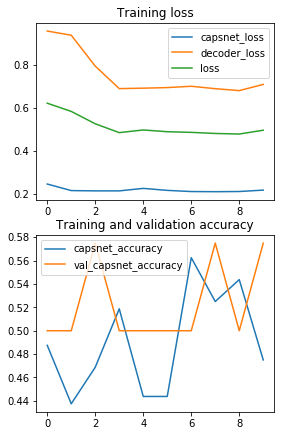

Trained model saved to './result/trained_model.h5'


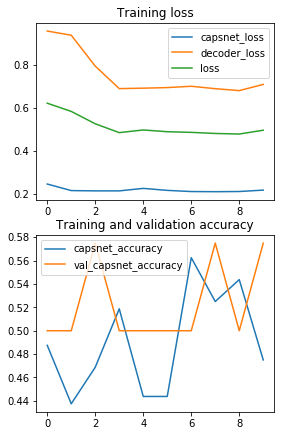

In [129]:
train(model=model, data=((train_features, y_tran), (validation_features, y_val)), args=args)

In [174]:
train(model=model, data=((x_tran, y_tran), (x_val, y_val)), args=args)


NameError: name 'x_tran' is not defined

# Show the results on the hold-out


------------------------------Begin: test------------------------------
Test acc: 0.0875

Reconstructed images are saved to ./result/real_and_recon.png
------------------------------End: test------------------------------


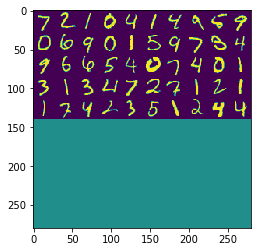

In [10]:


test(model=eval_model, data=(x_test, y_test), args=args)
#test(model=model, data=(x_test[:100], y_test[:100]))

In [ ]:
# pick some collabs stuff 

In [40]:
import tensorflow as tf

In [53]:
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

In [84]:
import os
import sys
from tensorflow.python.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization,MaxPool2D,GlobalMaxPool2D, TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def get_logits(labels, y_pred):
    s = 64.
    cos_t = y_pred
    sin_m = tf.math.sin(0.5)
    cos_m = tf.math.cos(0.5)
    mm = sin_m * 0.5  
    cos_t2 = tf.square(cos_t, name='cos_2')
    sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
    sin_t = tf.sqrt(sin_t2, name='sin_t')
    cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
    threshold = math.cos(math.pi - 0.5)
    cond_v = cos_t - threshold
    cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
    keep_val = s*(cos_t - mm)
    cos_mt_temp = tf.where(cond, cos_mt, keep_val)
    mask = tf.one_hot(labels, depth=2, name='one_hot_mask')
    inv_mask = tf.subtract(1., mask, name='inverse_mask')
    s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
    output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
    return output
def loss(y_true, y_pred):
    labels = K.argmax(y_true, axis=-1)
    logits = get_logits(labels, y_pred)
    loss = sparse_softmax_cross_entropy(labels=labels, logits=logits)
    return loss
effnet = EfficientNetB3(weights = "imagenet", include_top = False, input_shape=(224,244,3), pooling = None, classes = 2)
model = Sequential()
model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(5, activation='relu'))
model.add(Dense(2, activation="softmax"))
model.compile(loss=loss,
                      optimizer=Adam(lr=0.001), 
                  metrics=['acc'])
print(model.summary())

# Initialize model


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Model)       (None, 7, 8, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_16  (None, 1536)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 7685      
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 12        
Total params: 10,791,232
Trainable params: 10,703,929
Non-trainable params: 87,303
_________________________________________________________________
None


In [93]:
def cnn_effnet(shape=(112, 112, 3)):
    #model = EfficientNetB3(weights = "imagenet", include_top = False, input_shape=shape, pooling = None, classes = 2)
    model = Sequential()
    #model.add(effnet)
    momentum = .9
    model = Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    model.compile(loss=loss,
                        optimizer=Adam(lr=0.001), 
                    metrics=['acc'])
    print(model.summary())
    return model

In [82]:
model = cnn_effnet()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 112, 112, 64)      1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 56, 56, 128)       147584    
_________________________________________________________________
batch_normalization_14 (Batc (None, 56, 56, 128)     

In [97]:
def action_model(shape=(1, 112, 112, 3), nbout=2):
    # Create our convnet with (112, 112, 3) input shape
    convnet = cnn_effnet(shape[1:])
    
    # then create our final model
    model = Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [100]:
#INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
INSHAPE = (1, 112, 112, 3)
model = action_model(INSHAPE, )
optimizer = Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 112, 112, 64)      1792      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_29 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 56, 56, 128)       147584    
_________________________________________________________________
batch_normalization_30 (Batc (None, 56, 56, 128)     

In [95]:
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

NameError: name 'train' is not defined

In [101]:

# Initialize model
model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1)

Epoch 1/20


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_41 is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: [None, None, None, None]


In [105]:
data = {'FileName':[],'Label':[],'ClassName':[]}
for video_name in videos:
    for frames in frames_list:
        data['FileName'].append(os.path.join(dataset_path,frames))
        data['Label'].append(dict_of_labels[video_name])
        data['ClassName'].append(emotions)
data_frame = pd.DataFrame(data)
path = 'path to the corresponding folders'+d_type+'/{}_{}.csv'.format(video_name,frame_name)
data_frame.to_csv(filename)


NameError: name 'videos' is not defined

In [109]:
def filegenerator(CSV_folder,temporal_length,temporal_stride):
    for file in CSV_folder:
        data = pd.read_csv('path to each .csv file')
        labels = list(data.Label)
        img_list = list(data.FileName)
        samples = deque()
        sample_count = 0
    for img in img_list:
        samples.append(img)
        if len(samples)== temporal_length: 
            samples_c = copy.deepcopy(samples)
            samp_count += 1
            for i in range(temporal_stride):
                samples.popleft() 
            yield samples_c,labels[0]
            samples.popleft()

##Function to create the files structured based on the temporal requirements.:
def seq_of_frames(folder,d_type,length,stride):
    for csv_file in os.listdir(folder+'/'+d_type):
        file_gen = filegenerator(csv_file,temporal_length,temporal_stride)
        iterator = True
        data_list = []
        while iterator:
            try:
                X,y = next(file_gen)
                X = list(X) 
                data_list.append([X,y])
            except Exception as e:
                print("An exception has occured:",e)
                iterator = False
    return data_list

In [111]:
training_data = seq_of_frames('path to folder containing .csv files','Train',5,2)
validation_data= seq_of_frames('path to folder containing .csv files','Validation',5,2)


FileNotFoundError: [Errno 2] No such file or directory: 'path to folder containing .csv files/Train'

In [113]:
class DataGenerator(data_utils.Sequence):
    def __init__(self,data,batch_size,dim,n_classes,is_autoencoder,shuffle):
#Initializing the values
        self.dim = dim
        self.data  = data
        self.batch_size = batch_size
        self.list_IDs = np.arange(len(data))
        self.n_classes = n_classes
        self.is_autoencoder = is_autoencoder
        self.shuffle = shuffle
        self.on_epoch_end()

NameError: name 'data_utils' is not defined

In [ ]:
def on_epoch_end(self): 
    self.indexes = self.list_IDs  #Load the indexes of the data
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
def __len__(self): 
    return int(np.floor(len(self.data)/self.batch_size))
def __getitem__(self, index):
 #Generate batch at position 'index' 
    index = self.indexes[index*self.batch_size
    :(index+1)*self.batch_size]
    #Generate a temporary list of indexes that forms a batch based on  ##the index selected above.
    list_IDs_temp = [self.list_IDs[k] for k in index]
    #Generate batch
    X,y = self.__data_generation(list_IDs_temp)
        return X,y

In [122]:
def on_epoch_end(self): 
    self.indexes = self.list_IDs  
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
def __len__(self): 
    return int(np.floor(len(self.data)/self.batch_size))
def __getitem__(self, index):
    index = self.indexes[index*self.batch_size
    :(index+1)*self.batch_size]
    #Generate a temporary list of indexes that forms a batch based on  ##the index selected above.
    list_IDs_temp = [self.list_IDs[k] for k in index]
    #Generate batch
    X,y = self.__data_generation(list_IDs_temp)
    return X,y
def __data_generation(self,list_IDs_temp):
    X_data = []
    y_data = []
    for i,_ in enumerate(list_IDs_temp): #Iterating through each #
        seq_frames = self.data.iloc[i,0]
        y = self.data.iloc[i,1]
        temp_data_list = []
        for img in seq_frames:
            try:
                image = cv2.imread(img,0)
                ext_img = cv2.resize(image,self.dim)
            except Exception as e: 
                temp_data_list.append(ext_img)
        X_data.append(temp_data_list)
        y_data.append(y)
    X = np.array(X_data) 
    y = np.array(y_data)
    if self.is_autoencoder == True:
        return X, X
    else:
        return X, keras.utils.to_categorical(y,num_classes=self.n_classes)

In [128]:
model.fit(train_gen,epochs,validation_data=valid_gen,use_multiprocessing=True,workers=4)

KeyboardInterrupt: 

In [129]:
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
import numpy as np

class Extractor():
    def __init__(self, weights=None):
        """Either load pretrained from imagenet, or load our saved
        weights from our own training."""

        self.weights = weights  # so we can check elsewhere which model

        if weights is None:
            # Get model with pretrained weights.
            base_model = InceptionV3(
                weights='imagenet',
                include_top=True
            )

            # We'll extract features at the final pool layer.
            self.model = Model(
                inputs=base_model.input,
                outputs=base_model.get_layer('avg_pool').output
            )

        else:
            # Load the model first.
            self.model = load_model(weights)

            # Then remove the top so we get features not predictions.
            # From: https://github.com/fchollet/keras/issues/2371
            self.model.layers.pop()
            self.model.layers.pop()  # two pops to get to pool layer
            self.model.outputs = [self.model.layers[-1].output]
            self.model.output_layers = [self.model.layers[-1]]
            self.model.layers[-1].outbound_nodes = []

    def extract(self, image_path):
        img = image.load_img(image_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Get the prediction.
        features = self.model.predict(x)

        if self.weights is None:
            # For imagenet/default network:
            features = features[0]
        else:
            # For loaded network:
            features = features[0]

        return features


In [133]:
"""
Class for managing our data.
"""
import csv
import numpy as np
import random
import glob
import os.path
import sys
import operator
import threading
from tensorflow.keras.utils import to_categorical

class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

class DataSet():

    def __init__(self, seq_length=40, class_limit=None, image_shape=(224, 224, 3)):
        """Constructor.
        seq_length = (int) the number of frames to consider
        class_limit = (int) number of classes to limit the data to.
            None = no limit.
        """
        self.seq_length = seq_length
        self.class_limit = class_limit
        self.sequence_path = os.path.join('data', 'sequences')
        self.max_frames = 300  # max number of frames a video can have for us to use it

        # Get the data.
        self.data = self.get_data()

        # Get the classes.
        self.classes = self.get_classes()

        # Now do some minor data cleaning.
        self.data = self.clean_data()

        self.image_shape = image_shape

    @staticmethod
    def get_data():
        """Load our data from file."""
        with open(os.path.join('data', 'data_file.csv'), 'r') as fin:
            reader = csv.reader(fin)
            data = list(reader)

        return data

    def clean_data(self):
        """Limit samples to greater than the sequence length and fewer
        than N frames. Also limit it to classes we want to use."""
        data_clean = []
        for item in self.data:
            if int(item[3]) >= self.seq_length and int(item[3]) <= self.max_frames \
                    and item[1] in self.classes:
                data_clean.append(item)

        return data_clean

    def get_classes(self):
        """Extract the classes from our data. If we want to limit them,
        only return the classes we need."""
        classes = []
        for item in self.data:
            if item[1] not in classes:
                classes.append(item[1])

        # Sort them.
        classes = sorted(classes)

        # Return.
        if self.class_limit is not None:
            return classes[:self.class_limit]
        else:
            return classes

    def get_class_one_hot(self, class_str):
        """Given a class as a string, return its number in the classes
        list. This lets us encode and one-hot it for training."""
        # Encode it first.
        label_encoded = self.classes.index(class_str)

        # Now one-hot it.
        label_hot = to_categorical(label_encoded, len(self.classes))

        assert len(label_hot) == len(self.classes)

        return label_hot

    def split_train_test(self):
        """Split the data into train and test groups."""
        train = []
        test = []
        for item in self.data:
            if item[0] == 'train':
                train.append(item)
            else:
                test.append(item)
        return train, test

    def get_all_sequences_in_memory(self, train_test, data_type):
        """
        This is a mirror of our generator, but attempts to load everything into
        memory so we can train way faster.
        """
        # Get the right dataset.
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Loading %d samples into memory for %sing." % (len(data), train_test))

        X, y = [], []
        for row in data:

            if data_type == 'images':
                frames = self.get_frames_for_sample(row)
                frames = self.rescale_list(frames, self.seq_length)

                # Build the image sequence
                sequence = self.build_image_sequence(frames)

            else:
                sequence = self.get_extracted_sequence(data_type, row)

                if sequence is None:
                    print("Can't find sequence. Did you generate them?")
                    raise

            X.append(sequence)
            y.append(self.get_class_one_hot(row[1]))

        return np.array(X), np.array(y)

    @threadsafe_generator
    def frame_generator(self, batch_size, train_test, data_type):
        """Return a generator that we can use to train on. There are
        a couple different things we can return:

        data_type: 'features', 'images'
        """
        # Get the right dataset for the generator.
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Creating %s generator with %d samples." % (train_test, len(data)))

        while 1:
            X, y = [], []

            # Generate batch_size samples.
            for _ in range(batch_size):
                # Reset to be safe.
                sequence = None

                # Get a random sample.
                sample = random.choice(data)

                # Check to see if we've already saved this sequence.
                if data_type is "images":
                    # Get and resample frames.
                    frames = self.get_frames_for_sample(sample)
                    frames = self.rescale_list(frames, self.seq_length)

                    # Build the image sequence
                    sequence = self.build_image_sequence(frames)
                else:
                    # Get the sequence from disk.
                    sequence = self.get_extracted_sequence(data_type, sample)

                    if sequence is None:
                        raise ValueError("Can't find sequence. Did you generate them?")

                X.append(sequence)
                y.append(self.get_class_one_hot(sample[1]))

            yield np.array(X), np.array(y)

    def build_image_sequence(self, frames):
        """Given a set of frames (filenames), build our sequence."""
        return [process_image(x, self.image_shape) for x in frames]

    def get_extracted_sequence(self, data_type, sample):
        """Get the saved extracted features."""
        filename = sample[2]
        path = os.path.join(self.sequence_path, filename + '-' + str(self.seq_length) + \
            '-' + data_type + '.npy')
        if os.path.isfile(path):
            return np.load(path)
        else:
            return None

    def get_frames_by_filename(self, filename, data_type):
        """Given a filename for one of our samples, return the data
        the model needs to make predictions."""
        # First, find the sample row.
        sample = None
        for row in self.data:
            if row[2] == filename:
                sample = row
                break
        if sample is None:
            raise ValueError("Couldn't find sample: %s" % filename)

        if data_type == "images":
            # Get and resample frames.
            frames = self.get_frames_for_sample(sample)
            frames = self.rescale_list(frames, self.seq_length)
            # Build the image sequence
            sequence = self.build_image_sequence(frames)
        else:
            # Get the sequence from disk.
            sequence = self.get_extracted_sequence(data_type, sample)

            if sequence is None:
                raise ValueError("Can't find sequence. Did you generate them?")

        return sequence

    @staticmethod
    def get_frames_for_sample(sample):
        """Given a sample row from the data file, get all the corresponding frame
        filenames."""
        path = os.path.join('data', sample[0], sample[1])
        filename = sample[2]
        images = sorted(glob.glob(os.path.join(path, filename + '*jpg')))
        return images

    @staticmethod
    def get_filename_from_image(filename):
        parts = filename.split(os.path.sep)
        return parts[-1].replace('.jpg', '')

    @staticmethod
    def rescale_list(input_list, size):
        """Given a list and a size, return a rescaled/samples list. For example,
        if we want a list of size 5 and we have a list of size 25, return a new
        list of size five which is every 5th element of the origina list."""
        assert len(input_list) >= size

        # Get the number to skip between iterations.
        skip = len(input_list) // size

        # Build our new output.
        output = [input_list[i] for i in range(0, len(input_list), skip)]

        # Cut off the last one if needed.
        return output[:size]

    def print_class_from_prediction(self, predictions, nb_to_return=5):
        """Given a prediction, print the top classes."""
        # Get the prediction for each label.
        label_predictions = {}
        for i, label in enumerate(self.classes):
            label_predictions[label] = predictions[i]

        # Now sort them.
        sorted_lps = sorted(
            label_predictions.items(),
            key=operator.itemgetter(1),
            reverse=True
        )

        # And return the top N.
        for i, class_prediction in enumerate(sorted_lps):
            if i > nb_to_return - 1 or class_prediction[1] == 0.0:
                break
            print("%s: %.2f" % (class_prediction[0], class_prediction[1]))


In [130]:
"""
Process an image that we can pass to our networks.
"""
from keras.preprocessing.image import img_to_array, load_img
import numpy as np

def process_image(image, target_shape):
    """Given an image, process it and return the array."""
    # Load the image.
    h, w, _ = target_shape
    image = load_img(image, target_size=(h, w))

    # Turn it into numpy, normalize and return.
    img_arr = img_to_array(image)
    x = (img_arr / 255.).astype(np.float32)

    return x


In [134]:
"""
This script generates extracted features for each video, which other
models make use of.

You can change you sequence length and limit to a set number of classes
below.

class_limit is an integer that denotes the first N classes you want to
extract features from. This is useful is you don't want to wait to
extract all 101 classes. For instance, set class_limit = 8 to just
extract features for the first 8 (alphabetical) classes in the dataset.
Then set the same number when training models.
"""
import numpy as np
import os.path
from tqdm import tqdm

# Set defaults.
seq_length = 40
class_limit = None  # Number of classes to extract. Can be 1-101 or None for all.

# Get the dataset.
data = DataSet(seq_length=seq_length, class_limit=class_limit)

# get the model.
model = Extractor()

# Loop through data.
pbar = tqdm(total=len(data.data))
for video in data.data:

    # Get the path to the sequence for this video.
    path = os.path.join('data', 'sequences', video[2] + '-' + str(seq_length) + \
        '-features')  # numpy will auto-append .npy

    # Check if we already have it.
    if os.path.isfile(path + '.npy'):
        pbar.update(1)
        continue

    # Get the frames for this video.
    frames = data.get_frames_for_sample(video)

    # Now downsample to just the ones we need.
    frames = data.rescale_list(frames, seq_length)

    # Now loop through and extract features to build the sequence.
    sequence = []
    for image in frames:
        features = model.extract(image)
        sequence.append(features)

    # Save the sequence.
    np.save(path, sequence)

    pbar.update(1)

pbar.close()


FileNotFoundError: [Errno 2] No such file or directory: 'data/data_file.csv'

In [136]:
df_data

,id,label,dataset_type
0,youtube_04140.jpg,0,youtube
1,youtube_02810.jpg,0,youtube
2,youtube_05490.jpg,0,youtube
3,youtube_03030.jpg,0,youtube
4,youtube_00710_2.jpg,0,youtube
...,...,...,...
195,Deepfakes_04300_3.jpg,1,Deepfakes
196,Deepfakes_07110_2.jpg,1,Deepfakes
197,Deepfakes_01520.jpg,1,Deepfakes
198,Deepfakes_05470_3.jpg,1,Deepfakes


In [147]:
get_unique_video_names = df_data["id"]

In [140]:
get_unique_video_names

0          youtube_04140.jpg
1          youtube_02810.jpg
2          youtube_05490.jpg
3          youtube_03030.jpg
4        youtube_00710_2.jpg
               ...          
195    Deepfakes_04300_3.jpg
196    Deepfakes_07110_2.jpg
197      Deepfakes_01520.jpg
198    Deepfakes_05470_3.jpg
199    Deepfakes_00130_2.jpg
Name: id, Length: 200, dtype: object

In [166]:

unique_video_name = get_unique_video_names.str.split("_")[:][:]

In [161]:
unique_video_name

0           [youtube, 04140.jpg]
1           [youtube, 02810.jpg]
2           [youtube, 05490.jpg]
3           [youtube, 03030.jpg]
4        [youtube, 00710, 2.jpg]
                 ...            
195    [Deepfakes, 04300, 3.jpg]
196    [Deepfakes, 07110, 2.jpg]
197       [Deepfakes, 01520.jpg]
198    [Deepfakes, 05470, 3.jpg]
199    [Deepfakes, 00130, 2.jpg]
Name: id, Length: 200, dtype: object

In [1]:
unique_video_name.str.split("_").unqiue()

NameError: name 'unique_video_name' is not defined

In [176]:
list(list(zip(*unique_video_name))[1]) 

['04140.jpg',
 '02810.jpg',
 '05490.jpg',
 '03030.jpg',
 '00710',
 '02170',
 '03720.jpg',
 '02790.jpg',
 '01490',
 '03790.jpg',
 '01070',
 '01610.jpg',
 '01790.jpg',
 '00410.jpg',
 '01280',
 '00250.jpg',
 '03270.jpg',
 '02690.jpg',
 '02730.jpg',
 '01600',
 '00180',
 '01830.jpg',
 '01620.jpg',
 '00990',
 '03110.jpg',
 '05440.jpg',
 '02900.jpg',
 '03610.jpg',
 '03250.jpg',
 '02180',
 '04610.jpg',
 '00190.jpg',
 '04500.jpg',
 '00690.jpg',
 '04570.jpg',
 '04130',
 '01560.jpg',
 '05060.jpg',
 '01570.jpg',
 '01690',
 '04810',
 '03750.jpg',
 '01650.jpg',
 '00080',
 '04840',
 '04050.jpg',
 '02150.jpg',
 '01270',
 '04800.jpg',
 '04580',
 '00130.jpg',
 '02520.jpg',
 '04000.jpg',
 '03180.jpg',
 '00430.jpg',
 '00800',
 '01860',
 '02910',
 '00870.jpg',
 '00270.jpg',
 '01540',
 '03700.jpg',
 '00700',
 '03020.jpg',
 '05110.jpg',
 '01410.jpg',
 '02450.jpg',
 '03990',
 '03130.jpg',
 '01930.jpg',
 '00090',
 '02540.jpg',
 '02770',
 '04980.jpg',
 '00390',
 '01320.jpg',
 '02500.jpg',
 '01940.jpg',
 '00160.